In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
from sklearn.metrics import recall_score
from skimage import metrics
from sklearn.mixture import GaussianMixture as GMM
from scipy.io import loadmat
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw
from google.colab import drive
import time
# drive.mount('/content/drive')

In [ ]:
def show_image(img,scale=2.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()

# Part 1: SLIC Superpixels (50 Points)

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this problem, you will implement a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, you define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once you loop through all the clusters, you can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide covered in Lecture_17_Segmentation.pptx here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

## Helper Functions:

### Code (15 pts)

In [ ]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def display_clusters(img, clusters,scale):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        if c.h < image.shape[0] and c.w< image.shape[1]:
          image[c.h, c.w][0] = 0
          image[c.h, c.w][1] = 0
          image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image) 
    show_image(rgb_arr,scale)
    return rgb_arr

def display_clusters_hsv(img, clusters,scale):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        if c.h < image.shape[0] and c.w< image.shape[1]:
          image[c.h, c.w][0] = 0
          image[c.h, c.w][1] = 0
          image[c.h, c.w][2] = 0
    rgb_arr = color.hsv2rgb(image)
    show_image(rgb_arr,scale)
    return rgb_arr


In [ ]:
# Functions for Simple Linear Iterative Clustering (SLIC)
def toUint8(image):
    img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)  # normalize the data to 0 - 1
    return img
    
def initialize_cluster_centers(S, image, img_h, img_w, clusters):
    #### Write your code here ####
    # To Do: Initialize "clusters" by sampling pixels at an equally sampled regular grid (distanced by S)
    # on the image of N pixels. N = img_h X img_w. Hint: clusters.append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
    rgb_arr = color.lab2rgb(image) 
    for h in range(S//2,img_h,S):
      for w in range(S//2,img_w,S):
        clusters.append(make_SuperPixel(h,w,image))
    return clusters

def compute_gradient(h,w, image):
  Gx = np.linalg.norm(image[h][w + 1] - image[h][w - 1], ord=2) ** 2
  Gy = np.linalg.norm(image[h + 1][w] - image[h - 1][w], ord=2) ** 2
  return Gx + Gy


def relocate_cluster_center_at_lowgrad(clusters, image):
    #### Write your code here ####
    # To Do:
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient. 
    # Hint: c.update(img[x,y][0], img[h,w][1], img[x,y][2], x, y)
    for c in clusters:
      grad = compute_gradient(c.h,c.w,image)
      for h in range(c.h-1,c.h+2):
        for w in range(c.w-1, c.w+2):
          if h+1 < image.shape[0] and w+1 < image.shape[1]:
            new_grad = compute_gradient(h,w,image)
            if new_grad < grad:
              grad = new_grad
              c.update(image[h,w][0],image[h,w][1], image[h,w][2], h, w)
    return None

def get_nearby_clusters(clusters, S,h,w):
  nearby_clusters = []
  for c in clusters:
    if h-2*S <= c.h <= h+2*S and w-2*S <= c.w <= w+2*S:
      nearby_clusters.append(c)
  return nearby_clusters

def get_dist(c, h, w, l, a, b,S):
    m = 10
    ds = math.sqrt((c.h-h)**2 + (c.w-w)**2)
    dc = math.sqrt((c.l-l)**2 + (c.a-a)**2 + (c.b-b)**2)
    return math.sqrt(dc**2 + ((ds/S)**2)*m**2)

def get_dist_hsv(c, h, w, l, a, b,S):
    #new distance metric for hsv color space
    return math.sqrt((c.l-l)**2 + (c.a-a)**2 + (c.b-b)**2)

def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis):
    #### Write your code here ####
    # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster, 
    # Hints: 
    # 1. use "dis" matrix for comparing distances.
    # 2. You can use c.pixels.append((h, w)) to keep track of cluster-assignments.
    for h in range(img_h):
      for w in range(img_w):
        #find nearby clusters for (h,w)
        near_clusters = get_nearby_clusters(clusters, S, h, w)
        for c in near_clusters:
          l, a, b = image[h,w][0], image[h,w][1], image[h,w][2]
          dist = get_dist(c,h,w,l,a,b,S)
          #find the closest clusters by measuring distance
          if dist < dis[h,w]:
            dis[h,w] = dist
            if (h,w) in cluster_tag.keys():
              cluster_tag[(h,w)].pixels.remove((h,w))
            c.pixels.append((h,w))
            cluster_tag[(h,w)] = c
    return None

def assign_cluster_hsv(clusters, S, image, img_h, img_w, cluster_tag, dis):
    # assigning clusters based on a new distance metric for hsv color space
    for h in range(img_h):
      for w in range(img_w):
        #find nearby clusters for (h,w)
        near_clusters = get_nearby_clusters(clusters, S, h, w)
        for c in near_clusters:
          l, a, b = image[h,w][0], image[h,w][1], image[h,w][2]
          dist = get_dist_hsv(c,h,w,l,a,b,S)
          #find the closest clusters by measuring distance
          if dist < dis[h,w]:
            dis[h,w] = dist
            if (h,w) in cluster_tag.keys():
              cluster_tag[(h,w)].pixels.remove((h,w))
            c.pixels.append((h,w))
            cluster_tag[(h,w)] = c
    return None

def update_clusters(clusters, img_h, img_w):
    #### Write your code here ####
    # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
    h_sum = 0
    w_sum = 0
    count = 0
    for c in clusters:
      count = 0
      for pixel in c.pixels:
        h_sum += pixel[0]
        w_sum += pixel[1]
      h_new = h_sum // len(c.pixels)
      w_new = w_sum // len(c.pixels)
      if h_new <= img_h and w_new <=img_w:
        c.h = h_new
        c.w = w_new
    return None

def compute_res_error(old_clusters, new_clusters):
    #### Write your code here ####
    
    # error = Compute L1 distance between previous cluster-centres and new cluster centers.
    error_5d = 0.0
    res_error = 0.0
    for i in range(len(old_clusters)):
    #   error_5d += abs(old_clusters[i].h - new_clusters[i].h) + abs(old_clusters[i].w - new_clusters[i].w) + \
    # abs(old_clusters[i].l - new_clusters[i].l) + abs(old_clusters[i].a - new_clusters[i].a) + \
    # abs(old_clusters[i].b - new_clusters[i].b)
      res_error += abs(old_clusters[i].h - new_clusters[i].h) + abs(old_clusters[i].w - new_clusters[i].w)
    return res_error, error_5d

def slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis):

    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)

    # You can play around with these hyper-params.
    res_err = 123456789.0 # init residual_error with a very large value (choose as per your understanding.)
    threshold = 100 # tune this
    count = 0
    while(res_err >= threshold):

      assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis)
      old_clusters = copy.deepcopy(clusters)
      update_clusters(clusters,img_h, img_w)

      res_err, error_5d = compute_res_error(old_clusters, clusters)
      # if count==0:
        # print("Initialization error in 5D space is: ", error_5d)
      # print("residual error at iteration ",count, "is: ", res_err)
      if res_err<threshold:
        # print("5D space error at convergence: ", error_5d)
        break
      count +=1
      
    return clusters   

def slic_algorithm_hsv(S, image, img_h, img_w, clusters, cluster_tag, dis):
    # Modified SLIC with a new distance metric for hsv color space 

    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)

    # You can play around with these hyper-params.
    res_err = 123456789.0 # init residual_error with a very large value (choose as per your understanding.)
    threshold = 10 # tune this
    count = 0
    while(res_err >= threshold):

      assign_cluster_hsv(clusters, S, image, img_h, img_w, cluster_tag, dis)
      old_clusters = copy.deepcopy(clusters)
      update_clusters(clusters,img_h, img_w)

      res_err, error_5d = compute_res_error(old_clusters, clusters)
      # if count==0:
      #   print("Initialization error in 5D space is: ", error_5d)
      # print("residual error at iteration ",count, "is: ", res_err)
      if error_5d<threshold:
        # print("5D space error at convergence: ", error_5d)
        break
      count +=1
      
    return clusters   




In [ ]:
# SLIC for 10BSD Images:

img_names = ['10081', '14085', '14092','15011','15062','16004', '16068', '17067', '20069', '2018']
cluster_sizes = [64, 256, 1024]
print("\n Running SLIC for 10 BSD images \n")
for name in img_names:
  for cluster_size in cluster_sizes:
    
    img_path = "/content/Part1_SLIC/BSD_data/images/"+ name +".jpg"
    # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
    image = img_as_float(io.imread(img_path))

    # convert RGB to LAB
    image = color.rgb2lab(image)
    img_h = image.shape[0] #  Height
    img_w = image.shape[1] #  Width
    # k: Number of clusters/superpixels.
    k = cluster_size
    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel

    clusters = []
    cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
    dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
    start = time.time()
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis)
    stop = time.time()
    print("\n\nFor K = ", cluster_size)
    print("Time taken for the following result is: ", stop-start," seconds\n")
    display_clusters(image, clusters, 3)

In [ ]:
# SLIC for one image with three cluster sizes

img_name = '29030'
cluster_sizes = [64, 256, 1024]
print("\n Running SLIC for one image with 3 cluster sizes \n")
three_outputs = []

for cluster_size in cluster_sizes:
  start = time.time()
  img_path = "/content/Part1_SLIC/BSD_data/images/"+ img_name +".jpg"

  # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
  image = img_as_float(io.imread(img_path))

  # convert RGB to LAB
  image = color.rgb2lab(image)
  img_h = image.shape[0] #  Height
  img_w = image.shape[1] #  Width
  # k: Number of clusters/superpixels.
  k = cluster_size
  N = img_h * img_w  # Total pixels in the image
  S = int(math.sqrt(N /k)) # Average size of each superpixel

  clusters = []
  cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
  dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

  clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis)
  stop = time.time()
  print("\nFor K = ", cluster_size)
  print("Time taken for the following result is: ", stop-start," seconds\n")
  three_outputs.append(display_clusters(image, clusters, 3))


In [ ]:
#extra credit part 1 
data = loadmat('/content/Part1_SLIC/BSD_data/groundTruth/test/29030.mat')
# print(data.keys())
gt = data['groundTruth']
gt_boundary = gt[0][4][0][0][1]
cluster_sizes = [64, 256, 1024]
for i in range(len(three_outputs)):
  img = three_outputs[i]
  img = toUint8(img)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # Setting parameter values
  t_lower = 50  # Lower Threshold
  t_upper = 150  # Upper threshold

  # Applying the Canny Edge filter
  edge = cv2.Canny(blurred, t_lower, t_upper)
  splits, merges = metrics.variation_of_information(gt_boundary, edge)
  boundary_recall = recall_score(gt_boundary,edge,average='micro')

  print("boundary_recall for", cluster_sizes[i],"clusters:", boundary_recall)
  print("Under segmentation error for", cluster_sizes[i],"clusters:", merges,"\n")

boundary_recall for 64 clusters: 0.06354319180087847
Under segmentation error for 64 clusters: 0.15263224293507052 

boundary_recall for 256 clusters: 0.07379209370424597
Under segmentation error for 256 clusters: 0.15254988767375044 

boundary_recall for 1024 clusters: 0.09546120058565154
Under segmentation error for 1024 clusters: 0.15221074673616347 




 Running SLIC for one image with cluster size = 256 in HSV color space 


For K =  256
Time taken for the following result is:  23.743497610092163  seconds



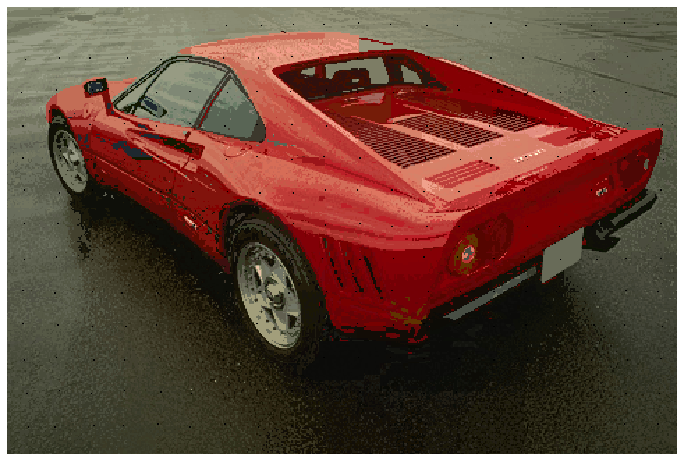

In [ ]:
#extra credit part 2
# SLIC for one image with cluster size = 256 and HSV color space
img_name = '29030'
cluster_sizes = [256]
print("\n Running SLIC for one image with cluster size = 256 in HSV color space \n")
image_256 = []

for cluster_size in cluster_sizes:
  start = time.time()
  img_path = "/content/Part1_SLIC/BSD_data/images/"+ img_name +".jpg"

  # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
  image = img_as_float(io.imread(img_path))

  # convert RGB to LAB
  image = color.rgb2hsv(image)
  # image = color.rgb2lab(image)
  img_h = image.shape[0] #  Height
  img_w = image.shape[1] #  Width
  # k: Number of clusters/superpixels.
  k = cluster_size
  N = img_h * img_w  # Total pixels in the image
  S = int(math.sqrt(N /k)) # Average size of each superpixel

  clusters = []
  cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
  dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

  clusters = slic_algorithm_hsv(S, image, img_h, img_w, clusters, cluster_tag, dis)
  stop = time.time()
  print("\nFor K = ", cluster_size)
  print("Time taken for the following result is: ", stop-start," seconds\n")
  image_256.append(display_clusters_hsv(image, clusters, 3))

In [ ]:
#extra credit part 2 continued

for i in range(len(image_256)):
  img = image_256[i]
  img = toUint8(img)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # Setting parameter values
  t_lower = 50  # Lower Threshold
  t_upper = 150  # Upper threshold

  # Applying the Canny Edge filter
  edge = cv2.Canny(blurred, t_lower, t_upper)
  splits, merges = metrics.variation_of_information(gt_boundary, edge)
  boundary_recall = recall_score(gt_boundary,edge,average='micro')

  print("boundary_recall for", cluster_sizes[i],"clusters:", boundary_recall)
  print("Under segmentation error for", cluster_sizes[i],"clusters:", merges,"\n")

boundary_recall for 256 clusters: 0.09165446559297218
Under segmentation error for 256 clusters: 0.15236984754905972 



### Write-up (35 pts)
* a) [5 points] Explain your distance function for measuring the similarity between a pixel and cluster in the 5D space.
* b) [5 points] Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.
* c) [5 points] Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.
* d) [10 points] Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.
* e)  [10 points] Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.

### Respones

* a) The distance metric I used is D = (Dc^2 + (Ds/S)^2 * m^2)^0.5. Where Dc is L2 distance norm of l,a,b values and Ds is the L2 norm of position values. 'm' is weight for spatial proximity. When 'm' is large, spatial proximity os more importnat and the resulting superpixels are more compact. And when 'm' is small the resulting superpixels adhere more tightly to image boundaries, but have less regular size and shape.

* b) The following segmentation is using m = 10 (i.e 10 as weight for spatial proximity)
(I was not able to get the images to display in the pdf. Please refere the colab notebook to view the images.
<table><tr>
<td><img src="https://drive.google.com/uc?id=1JIxtR_ZMI3jmodlVpyv92MifXh-jxuPy" alt="Drawing" style="width: 150px;"/> </td>
</table>

The following segmentation is using m = 20 (i.e 10 as weight for spatial proximity):
<table><tr>
<td><img src="https://drive.google.com/uc?id=1JAcFTPxAjqNGc90q8fEyBCNPPqQXyUEA" alt="Drawing" style="width: 150px;"/> </td>
</table>

The following segmentation is using m = 30 (i.e 10 as weight for spatial proximity):
<table><tr>
<td><img src="https://drive.google.com/uc?id=1PSwgKLAJGQBhnpvsvvQ3uuEu3OlUv17a" alt="Drawing" style="width: 150px;"/> </td>
</table>

As we can see that, as the weightage for the spatial proximity increases, the color space distance is increasing, i.e some are wrongly segmented based on color as it is giving more importance to the proximity of the pixel to the cluster center.

* c) The errors for each iteration is printed above. 

* d) It is printed above in the cell where one image with 3 cluster sizes are showed.

* e) Shown above.

### Extra Credit (20 pts)
* f) [upto 10 points] Implement and report two types of metrics (1) boundary recall and (2) under-segmentation error with K = 64, 256 and 1024 on the BSD (last part of write-up).
* g) [upto 10 points] Try to improve your result from first part of extra-credit. You may try different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features (e.g., gradients) or any other ideas you come up with. Report the accuracy on boundary recall and under-segmentation error with K = 256. Compare the results with first-part of extra-credit and explain why you get better results.


### Responses for Extra Credit

* f)  
* First, a hard boundary map of the segmented image was generated using canny edge detector and was used as predicted truth for comparing the True positives between the given ground truth boundary and the predicted boundary. 
It is observed that the boundary recall value increases as the number of clusters increase, as the accuracy of segmentation increases and hence the chance of including true edge increases.  
  
* To compute the under segmentation error, a function from skimage metrics called 'variation_of_information' was used, which takes the ground truth and predicted output as the input. This function returns merges and splits which is basically under and over segmentation error as the merges means the area which actually have to segmented but in the predicted output it was not segmented and considered as same cluster or boundary. Hence, this merges metric represents the under segmentation error. We can observe that as the cluster size increases, the under segmentation error decreases, this is because as the clusters increase, the probability of segmenting increases and hence gets closer to true segmentation.  
    
* The outputs of the mentioned pipeline is as follows (printed above):  

  boundary_recall for 64 clusters: 0.06354319180087847  
  Under segmentation error for 64 clusters: 0.15263224293507052  

  boundary_recall for 256 clusters: 0.07379209370424597  
  Under segmentation error for 256 clusters: 0.15254988767375044  

  boundary_recall for 1024 clusters: 0.09546120058565154  
  Under segmentation error for 1024 clusters: 0.15221074673616347  
    
    
* g)  

* To improve the boundary recall value and reduce the under segmentation error, I first tried chaning the color space to hsv, with distance metric same as that used for CIElab color space. The results did not improve noticebly. Hence, as suggested in the SLIC paper, I considered a distance metric which is the L2 norm of color space vector. After tuning the threshold, the boundary recall increased slightly and the undersegmentatin error reduced.  
* The values for lab color space and standard distance metric:  
boundary_recall for 256 clusters: 0.07379209370424597  
Under segmentation error for 256 clusters: 0.15254988767375044  
  
* The values for hsv color space and new distance metric:  
  boundary_recall for 256 clusters: 0.09253294289897511  
  Under segmentation error for 256 clusters: 0.15234202407978195  
    
  We can see that the boundary recall values have improved and the error value has slightly decreased.  

* The results improved because hsv color space offers robustness to intensity values of pixels and hence helps in categorizing the pixel properly. The new distance metric considered takes the distance in color space which guarantees the connectivity in the xy plane.

  






